## Install Dependencies

In [ ]:
# Install build dependencies first
!apt-get install -y build-essential python3-dev

# Install hmmlearn from the precompiled wheel compatible with Colab (Python 3.12)
!pip install --no-cache-dir --prefer-binary "hmmlearn>=0.3.2"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 62.8 MB/s eta 0:00:00


## Import Core Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from hmmlearn.hmm import GaussianHMM, MultinomialHMM
import warnings
warnings.filterwarnings("ignore")

print("✅ hmmlearn imported successfully!")

✅ hmmlearn imported successfully!


## Helper Functions for Evaluation of Confusion Matrix and Plotting ROC Curve

In [ ]:
def evaluate_preds(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    # For ROC/AUC we need probability or scores. HMM doesn't give predict_proba; use predicted labels for ROC curve (works but AUC limited)
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
    except:
        fpr, tpr, roc_auc = [0],[0],0.0
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "cm": cm, "fpr": fpr, "tpr": tpr, "auc": roc_auc}

def plot_conf_matrix(cm, title, savepath=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_roc(fpr, tpr, roc_auc, title, savepath=None):
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'r--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_training_loss(losses, title, savepath=None):
    plt.figure(figsize=(6,4))
    plt.plot(losses, marker='o')
    plt.title(title)
    plt.xlabel("Epoch (iteration over repeated fits)")
    plt.ylabel("Negative Log Likelihood (loss)")
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

## Fetch Datasets

In [ ]:
print("Loading datasets...")
iono = fetch_openml(name='ionosphere', version=1, as_frame=True)
X_iono = iono.data.astype(float)
y_iono = LabelEncoder().fit_transform(iono.target)  # Good/Bad -> 0/1

bc = fetch_openml(name='breast-w', version=1, as_frame=True)   # 'breast-w' is older; we select numeric features
# sometimes fetch_openml returns 'class' target as 'benign'/'malignant'
X_bc = bc.data.select_dtypes(include=[np.number]).astype(float).fillna(0)  # keep numeric features only
y_bc = LabelEncoder().fit_transform(bc.target)

datasets = {
    "Ionosphere": (X_iono, y_iono),
    "BreastCancerDiag": (X_bc, y_bc)
}


Loading datasets...


## Define Model Parameters and Grids

In [ ]:
gaussian_default = {"n_components": 2, "n_iter": 50}
multinomial_default = {"n_components": 2, "n_iter": 50, "bins": 10}

# define grid for tuning
gaussian_grid = [
    {"n_components": 2, "n_iter": 50},
    {"n_components": 2, "n_iter": 200},
    {"n_components": 4, "n_iter": 200},
    {"n_components": 6, "n_iter": 200},
]
multinomial_grid = [
    {"n_components": 2, "n_iter": 50, "bins": 5},
    {"n_components": 2, "n_iter": 200, "bins": 10},
    {"n_components": 4, "n_iter": 200, "bins": 10},
    {"n_components": 4, "n_iter": 200, "bins": 15},
]


## Train and Evaluate Models

In [ ]:
results = []  # will collect all runs
best_cases = {}  # store best case per (dataset, classifier)

for dataset_name, (X_raw, y_raw) in datasets.items():
    print(f"\n===== Dataset: {dataset_name} =====")
    # Standardize continuous features for Gaussian HMM
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    for split in [0.8, 0.7]:
        test_size = 1.0 - split
        X_train_full, X_test_full, y_train, y_test = train_test_split(X_scaled, y_raw, test_size=test_size, random_state=42, stratify=y_raw)
        print(f"\n--- Train/Test split {int(split*100)}-{int(test_size*100)} ---")

        # 5A) Without tuning runs
        # Gaussian - default
        model_name = "GaussianHMM"
        params = gaussian_default.copy()
        print(f"Running {model_name} WITHOUT tuning: {params}")
        gaussian_model = GaussianHMM(n_components=params["n_components"], covariance_type="diag", n_iter=params["n_iter"], random_state=42)
        # Loss tracking: repeated fit (10 iterations) to show loss curve
        gaussian_losses = []
        for epoch in range(10):
            gaussian_model.fit(X_train_full)
            gaussian_losses.append(-gaussian_model.score(X_train_full))
        # Predictions: For HMM used as classifier we treat each sample independently (predict returns state index)
        y_pred = []
        for x in X_test_full:
            try:
                y_pred.append(gaussian_model.predict([x])[0])
            except:
                y_pred.append(np.random.randint(0,2))
        # But the HMM states (0..n_components-1) don't map to labels directly. We need to map HMM states -> class labels.
        # We'll map by majority vote between predicted states for train set and y_train.
        # Create mapping from HMM state -> class (0/1) using training set
        train_state_seq = gaussian_model.predict(X_train_full)
        state_to_label = {}
        for st in np.unique(train_state_seq):
            # assign class that majority of train samples with this state have
            mask = (train_state_seq == st)
            if mask.sum() == 0:
                state_to_label[st] = 0
            else:
                state_to_label[st] = int(pd.Series(y_train[mask]).mode()[0])
        # convert predictions
        y_pred_mapped = np.array([state_to_label.get(s,0) for s in y_pred])
        metrics = evaluate_preds(y_test, y_pred_mapped)
        results.append([dataset_name, split, model_name, "Without_Tuning", params, metrics])
        # Save best
        key = (dataset_name, model_name)
        if key not in best_cases or metrics["accuracy"] > best_cases[key]["metrics"]["accuracy"]:
            best_cases[key] = {"model": gaussian_model, "params": params, "metrics": metrics, "losses": gaussian_losses, "state_map": state_to_label, "split": split}

        # Multinomial - default (discretize)
        model_name = "MultinomialHMM"
        params = multinomial_default.copy()
        print(f"Running {model_name} WITHOUT tuning: {params}")
        # Discretize features with KBinsDiscretizer
        disc = KBinsDiscretizer(n_bins=params["bins"], encode='ordinal', strategy='uniform')
        X_train_disc = disc.fit_transform(X_train_full).astype(int)
        X_test_disc = disc.transform(X_test_full).astype(int)
        multinomial_model = MultinomialHMM(n_components=params["n_components"], n_iter=params["n_iter"], random_state=42)
        multinomial_losses = []
        for epoch in range(10):
            multinomial_model.fit(X_train_disc)
            multinomial_losses.append(-multinomial_model.score(X_train_disc))
        # Predictions then map states -> labels similar to Gaussian
        y_pred = []
        for x in X_test_disc:
            try:
                y_pred.append(multinomial_model.predict([x])[0])
            except:
                y_pred.append(np.random.randint(0,2))
        train_state_seq = multinomial_model.predict(X_train_disc)
        state_to_label = {}
        for st in np.unique(train_state_seq):
            mask = (train_state_seq == st)
            if mask.sum() == 0:
                state_to_label[st] = 0
            else:
                state_to_label[st] = int(pd.Series(y_train[mask]).mode()[0])
        y_pred_mapped = np.array([state_to_label.get(s,0) for s in y_pred])
        metrics = evaluate_preds(y_test, y_pred_mapped)
        results.append([dataset_name, split, model_name, "Without_Tuning", params, metrics])
        key = (dataset_name, model_name)
        if key not in best_cases or metrics["accuracy"] > best_cases[key]["metrics"]["accuracy"]:
            best_cases[key] = {"model": multinomial_model, "params": params, "metrics": metrics, "losses": multinomial_losses, "state_map": state_to_label, "split": split, "discretizer": disc}

        # 5B) WITH tuning: grid search over parameter grids
        # Gaussian tuning grid evaluation
        print("\n-- GaussianHMM grid search (With_Tuning) --")
        for gparams in gaussian_grid:
            model = GaussianHMM(n_components=gparams["n_components"], covariance_type="diag", n_iter=gparams["n_iter"], random_state=42)
            losses = []
            for epoch in range(8):  # fewer epochs per candidate to speed up
                model.fit(X_train_full)
                losses.append(-model.score(X_train_full))
            # predictions and mapping
            train_state_seq = model.predict(X_train_full)
            state_to_label = {}
            for st in np.unique(train_state_seq):
                mask = (train_state_seq == st)
                if mask.sum() == 0:
                    state_to_label[st] = 0
                else:
                    state_to_label[st] = int(pd.Series(y_train[mask]).mode()[0])
            y_pred = []
            for x in X_test_full:
                try:
                    y_pred.append(model.predict([x])[0])
                except:
                    y_pred.append(np.random.randint(0,2))
            y_pred_mapped = np.array([state_to_label.get(s,0) for s in y_pred])
            metrics = evaluate_preds(y_test, y_pred_mapped)
            results.append([dataset_name, split, "GaussianHMM", "With_Tuning", gparams, metrics])
            key = (dataset_name, "GaussianHMM")
            if key not in best_cases or metrics["accuracy"] > best_cases[key]["metrics"]["accuracy"]:
                best_cases[key] = {"model": model, "params": gparams, "metrics": metrics, "losses": losses, "state_map": state_to_label, "split": split}

        # Multinomial tuning grid evaluation
        print("\n-- MultinomialHMM grid search (With_Tuning) --")
        for mparams in multinomial_grid:
            disc = KBinsDiscretizer(n_bins=mparams["bins"], encode='ordinal', strategy='uniform')
            X_train_disc = disc.fit_transform(X_train_full).astype(int)
            X_test_disc = disc.transform(X_test_full).astype(int)
            model = MultinomialHMM(n_components=mparams["n_components"], n_iter=mparams["n_iter"], random_state=42)
            losses = []
            for epoch in range(8):
                model.fit(X_train_disc)
                losses.append(-model.score(X_train_disc))
            train_state_seq = model.predict(X_train_disc)
            state_to_label = {}
            for st in np.unique(train_state_seq):
                mask = (train_state_seq == st)
                if mask.sum() == 0:
                    state_to_label[st] = 0
                else:
                    state_to_label[st] = int(pd.Series(y_train[mask]).mode()[0])
            y_pred = []
            for x in X_test_disc:
                try:
                    y_pred.append(model.predict([x])[0])
                except:
                    y_pred.append(np.random.randint(0,2))
            y_pred_mapped = np.array([state_to_label.get(s,0) for s in y_pred])
            metrics = evaluate_preds(y_test, y_pred_mapped)
            results.append([dataset_name, split, "MultinomialHMM", "With_Tuning", mparams, metrics])
            key = (dataset_name, "MultinomialHMM")
            if key not in best_cases or metrics["accuracy"] > best_cases[key]["metrics"]["accuracy"]:
                best_cases[key] = {"model": model, "params": mparams, "metrics": metrics, "losses": losses, "state_map": state_to_label, "split": split, "discretizer": disc}

print("\n\n=== All experiments finished ===")


===== Dataset: Ionosphere =====

--- Train/Test split 80-19 ---
Running GaussianHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50}


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Running MultinomialHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50, 'bins': 10}



-- GaussianHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



-- MultinomialHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- Train/Test split 70-30 ---
Running GaussianHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50}


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Running MultinomialHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50, 'bins': 10}



-- GaussianHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



-- MultinomialHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



===== Dataset: BreastCancerDiag =====

--- Train/Test split 80-19 ---
Running GaussianHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50}


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Running MultinomialHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50, 'bins': 10}



-- GaussianHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



-- MultinomialHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- Train/Test split 70-30 ---
Running GaussianHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50}


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Running MultinomialHMM WITHOUT tuning: {'n_components': 2, 'n_iter': 50, 'bins': 10}



-- GaussianHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



-- MultinomialHMM grid search (With_Tuning) --


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340




=== All experiments finished ===


## Compile and Save Experiment Results

In [ ]:
rows = []
for ds, split, modelname, tuning, params, metrics in results:
    rows.append({
        "Dataset": ds,
        "Split": split,
        "Model": modelname,
        "Tuning": tuning,
        "Params": str(params),
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1": metrics["f1"],
        "AUC": metrics["auc"]
    })

df_results = pd.DataFrame(rows)
# Sort for readability
df_results = df_results.sort_values(by=["Dataset","Model","Tuning","Accuracy"], ascending=[True,True,True,False]).reset_index(drop=True)
print("\n=== Results Table (sample) ===")
display(df_results.head(40))

# Save CSV
df_results.to_csv("HMM_Results_Tuned_vs_Untuned.csv", index=False)
print("Saved HMM_Results_Tuned_vs_Untuned.csv")



=== Results Table (sample) ===


,Dataset,Split,Model,Tuning,Params,Accuracy,Precision,Recall,F1,AUC
0,BreastCancerDiag,0.7,GaussianHMM,With_Tuning,"{'n_components': 2, 'n_iter': 50}",0.904762,0.882353,0.833333,0.857143,0.887681
1,BreastCancerDiag,0.7,GaussianHMM,With_Tuning,"{'n_components': 2, 'n_iter': 200}",0.904762,0.882353,0.833333,0.857143,0.887681
2,BreastCancerDiag,0.7,GaussianHMM,With_Tuning,"{'n_components': 4, 'n_iter': 200}",0.657143,0.000000,0.000000,0.000000,0.500000
3,BreastCancerDiag,0.7,GaussianHMM,With_Tuning,"{'n_components': 6, 'n_iter': 200}",0.657143,0.000000,0.000000,0.000000,0.500000
4,BreastCancerDiag,0.8,GaussianHMM,With_Tuning,"{'n_components': 2, 'n_iter': 50}",0.342857,0.342857,1.000000,0.510638,0.500000
5,BreastCancerDiag,0.8,GaussianHMM,With_Tuning,"{'n_components': 2, 'n_iter': 200}",0.342857,0.342857,1.000000,0.510638,0.500000
6,BreastCancerDiag,0.8,GaussianHMM,With_Tuning,"{'n_components': 4, 'n_iter': 200}",0.342857,0.342857,1.000000,0.510638,0.500000
7,BreastCancerDiag,0.8,GaussianHMM,With_Tuning,"{'n_components': 6, 'n_iter': 200}",0.342857,0.342857,1.000000,0.510638,0.500000
8,BreastCancerDiag,0.7,GaussianHMM,Without_Tuning,"{'n_components': 2, 'n_iter': 50}",0.904762,0.882353,0.833333,0.857143,0.887681
9,BreastCancerDiag,0.8,GaussianHMM,Without_Tuning,"{'n_components': 2, 'n_iter': 50}",0.342857,0.342857,1.000000,0.510638,0.500000


Saved HMM_Results_Tuned_vs_Untuned.csv


## Best Cases per Dataset and Classifier


=== Best cases per dataset & classifier ===

--- Best for Ionosphere - GaussianHMM ---


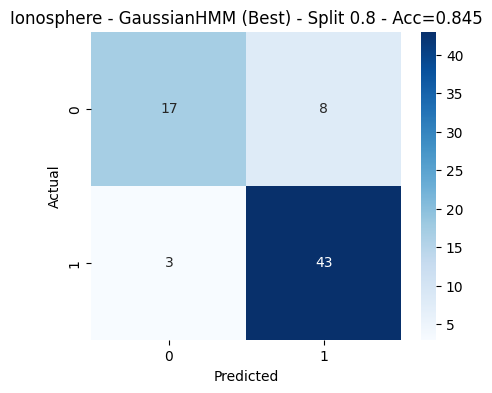

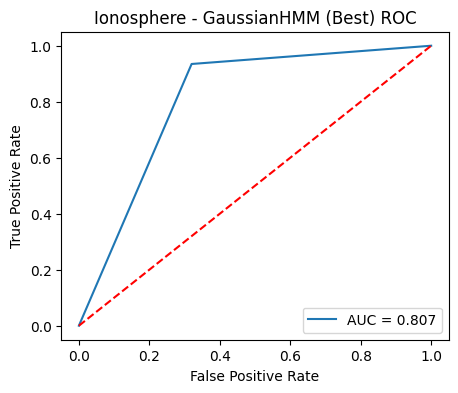

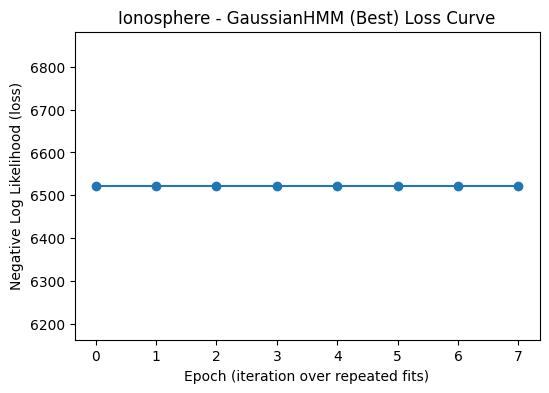


--- Best for Ionosphere - MultinomialHMM ---


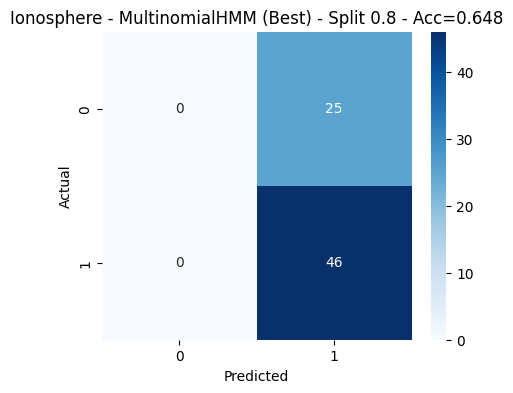

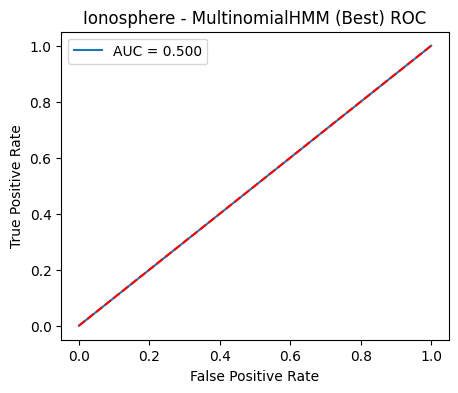

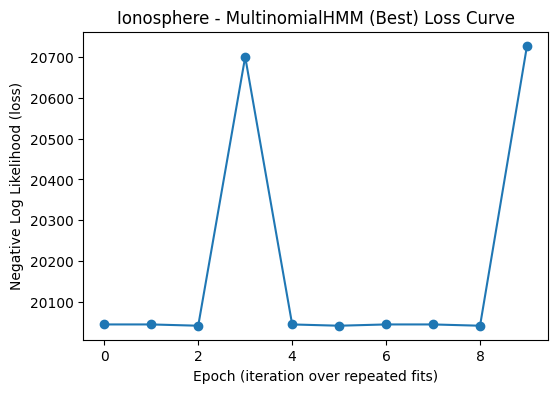


--- Best for BreastCancerDiag - GaussianHMM ---


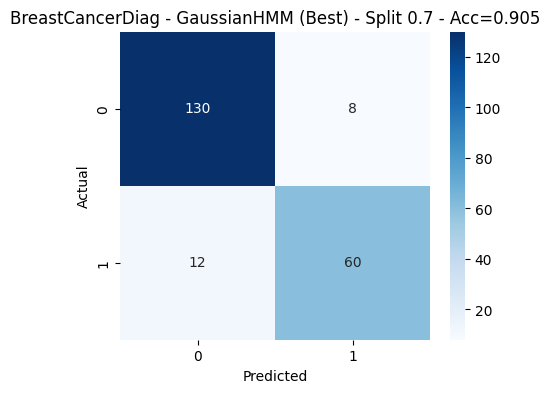

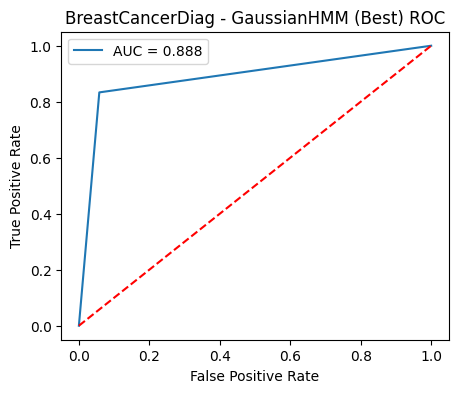

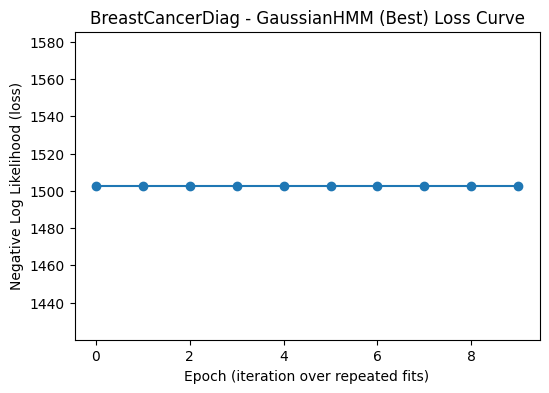


--- Best for BreastCancerDiag - MultinomialHMM ---


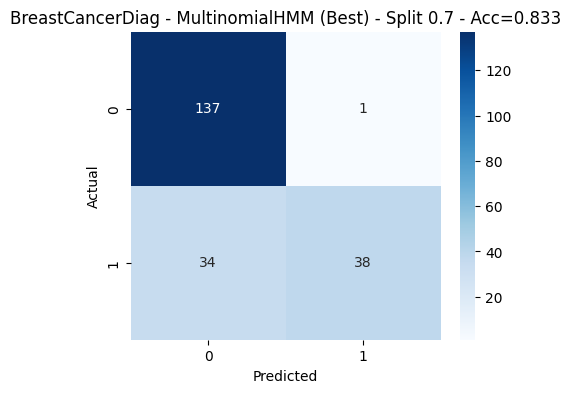

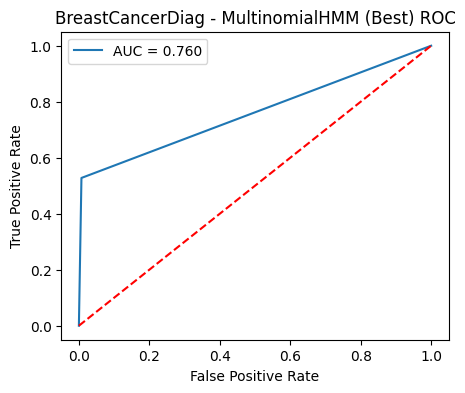

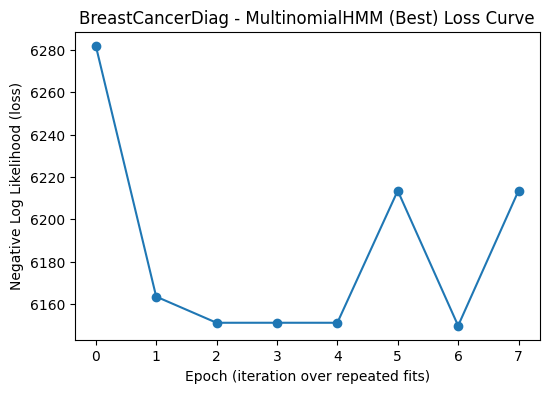

In [ ]:
print("\n=== Best cases per dataset & classifier ===")
for key, info in best_cases.items():
    dataset_name, classifier_name = key
    print(f"\n--- Best for {dataset_name} - {classifier_name} ---")
    metrics = info["metrics"]
    # confusion matrix
    cm = metrics["cm"]
    title_cm = f"{dataset_name} - {classifier_name} (Best) - Split {info.get('split', 'NA')} - Acc={metrics['accuracy']:.3f}"
    plot_conf_matrix(cm, title_cm, savepath=f"{dataset_name}_{classifier_name}_best_confmat.png")
    # ROC
    fpr, tpr = metrics["fpr"], metrics["tpr"]
    roc_auc = metrics["auc"]
    plot_roc(fpr, tpr, roc_auc, f"{dataset_name} - {classifier_name} (Best) ROC", savepath=f"{dataset_name}_{classifier_name}_best_roc.png")
    # Loss curve (if tracked)
    losses = info.get("losses", [])
    if len(losses) > 0:
        plot_training_loss(losses, f"{dataset_name} - {classifier_name} (Best) Loss Curve", savepath=f"{dataset_name}_{classifier_name}_best_loss.png")


## Final Comparison (Grouped Summary)

In [ ]:
print("\n=== Final comparison (grouped summary) ===")
summary = df_results.groupby(["Dataset","Model","Tuning"]).agg({
    "Accuracy":"mean",
    "Precision":"mean",
    "Recall":"mean",
    "F1":"mean",
    "AUC":"mean"
}).reset_index().sort_values(by=["Dataset","Model","Tuning","Accuracy"], ascending=[True,True,True,False])
display(summary)
summary.to_csv("HMM_Summary_Aggregated.csv", index=False)
print("Saved HMM_Summary_Aggregated.csv")


=== Final comparison (grouped summary) ===


,Dataset,Model,Tuning,Accuracy,Precision,Recall,F1,AUC
0,BreastCancerDiag,GaussianHMM,With_Tuning,0.561905,0.392017,0.708333,0.469605,0.596920
1,BreastCancerDiag,GaussianHMM,Without_Tuning,0.623810,0.612605,0.916667,0.683891,0.693841
2,BreastCancerDiag,MultinomialHMM,With_Tuning,0.522619,0.418223,0.567708,0.344329,0.533401
3,BreastCancerDiag,MultinomialHMM,Without_Tuning,0.533333,0.671429,0.597222,0.418110,0.548611
4,Ionosphere,GaussianHMM,With_Tuning,0.753505,0.816909,0.839514,0.808546,0.717191
5,Ionosphere,GaussianHMM,Without_Tuning,0.776575,0.811473,0.897059,0.839611,0.725635
6,Ionosphere,MultinomialHMM,With_Tuning,0.570755,0.482727,0.750000,0.587386,0.500000
7,Ionosphere,MultinomialHMM,Without_Tuning,0.644698,0.644698,1.000000,0.783967,0.500000


Saved HMM_Summary_Aggregated.csv
